# Timeseries module - demo

`pynsitu.tseries` implements methods useful to the time series analysis

Assumptions about the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pynsitu as pin

/Users/aponte/Code/pynsitu/pynsitu/tseries.py:927: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "alpha" is not None:


---

## generate synthetic time series


In [12]:
tdefault = dict(start="2018-01-01", end="2018-01-30", freq="1H")

def generate_time_series(
    label="time", uniform=True, time_units="datetime"
):
    """Create a drifter time series."""
    time = pd.date_range(**tdefault)
    time_scale = pd.Timedelta("1D")
    if time_units == "timedelta":
        time = time - time[0]
    elif time_units == "numeric":
        time = (time - time[0]) / pd.Timedelta("1H")
        time_scale = 1.0
    if not uniform:
        nt = time.size
        import random
        time = time[random.sample(range(nt), 2 * nt // 3)].sort_values()
    #
    v0 = (
        np.cos(2 * np.pi * ((time - time[0]) / time_scale))
        + np.random.randn(time.size) / 2
    )
    v1 = (
        np.sin(2 * np.pi * ((time - time[0]) / time_scale))
        + np.random.randn(time.size) / 2
    )
    df = pd.DataFrame({"v0": v0, "v1": v1, label: time})
    df = df.set_index(label)
    return df

In [3]:
# actually generate one time series
df = generate_time_series(uniform=False)
df.head()

,v0,v1
time,,
2018-01-01 00:00:00,0.700461,-0.039145
2018-01-01 01:00:00,1.637388,0.786590
2018-01-01 04:00:00,0.716041,0.700783
2018-01-01 07:00:00,-0.412412,0.645213
2018-01-01 08:00:00,-0.130969,0.773983


<Axes: xlabel='time'>

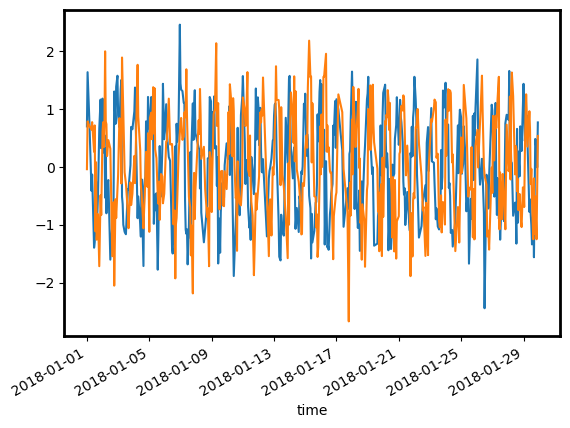

In [4]:
df.v0.plot()
df.v1.plot()

---

## basic editing

### triming based on deployment information

<Axes: xlabel='time'>

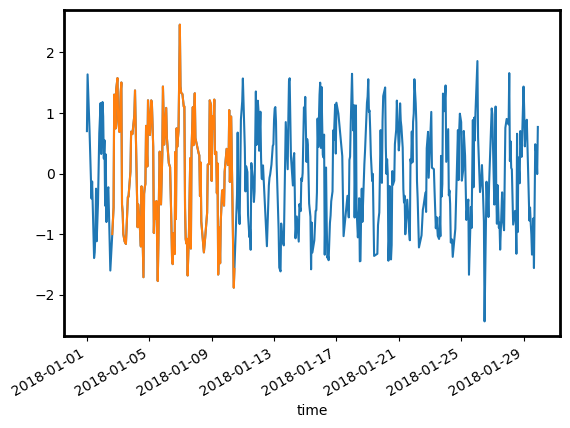

In [5]:
d = pin.events.Deployment(
    "some_event",
    start="2018/01/02 12:12:00",
    end="2018/01/10 12:12:00",
)

df_trimmed = df.ts.trim(d)

df.v0.plot()
df_trimmed.v0.plot()

### resampling on a regular timeline

In [6]:
df_resampled = df.ts.resample_uniform("1H")

(17532.708333333332, 17534.0)

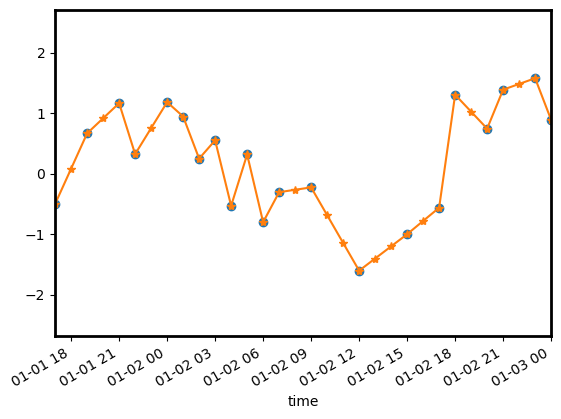

In [7]:
fig, ax = plt.subplots(1, 1)
df.v0.plot(marker="o", ls="None")
df_resampled.v0.plot(marker="*")
ax.set_xlim(df.index[10], df.index[30])

---
## spectral analysis

In [8]:
E = df_resampled.ts.spectrum(nperseg=24 * 5)
E.head()

,v0,v1
frequency,,
-0.000139,207.991819,246.959078
-0.000137,229.585106,303.950287
-0.000134,195.131519,290.181291
-0.000132,244.325855,309.730065
-0.000130,332.657953,501.975631


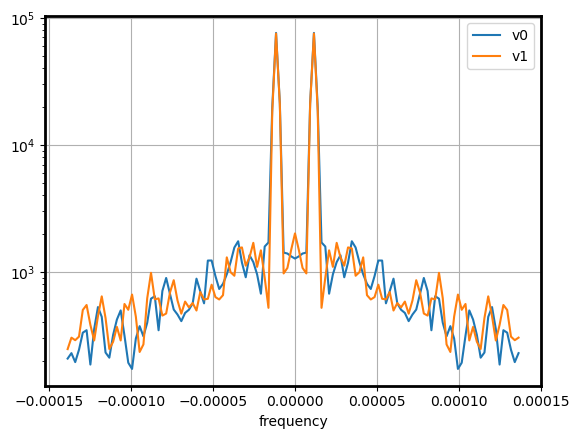

In [9]:
E.plot()
plt.yscale("log")
plt.grid()

---
## filtering

to be done ...

---
## tidal analysis

to be done ...

---
## with xarray objects

In [10]:
ds = df_resampled.to_xarray().expand_dims(x=range(10)).chunk(dict(x=2))
ds

<xarray.Dataset>
Dimensions:  (x: 10, time: 695)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-01-29T22:00:00
Data variables:
    v0       (x, time) float64 dask.array<chunksize=(2, 695), meta=np.ndarray>
    v1       (x, time) float64 dask.array<chunksize=(2, 695), meta=np.ndarray>

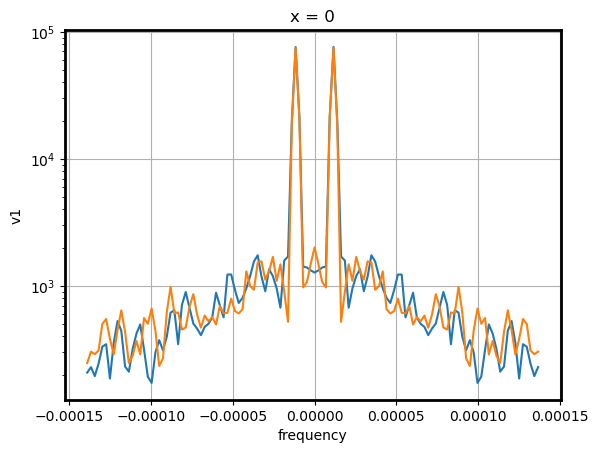

In [11]:
E = ds.ts.spectrum(nperseg=24 * 5)
E.v0.isel(x=0).plot()
E.v1.isel(x=0).plot()
plt.yscale("log")
plt.grid()